In [1]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

from typing import  TypedDict,Annotated
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
load_dotenv()

True

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages]



In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")

In [4]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(max_result = 2)


In [17]:
def multiply(a:int,b:int)->int:
    
    """
    This tool multiply two values 
    Args:
    a: first integer
    b: second integer
    """
    return a*b

In [18]:
tools = [multiply,search_tool]

llm_with_tool = llm.bind_tools(tools)


In [19]:
def tool_calling_condition(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

In [20]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


graph = StateGraph(State)

graph.add_node("tool_calling_llm",tool_calling_condition)

graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tool_calling_llm")

graph.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is a tool call -> tool condition route to tools
    # if the latest message from assistant is not tool call -> tool condtion route to END
    tools_condition
)

graph.add_edge("tools",END)

app = graph.compile()

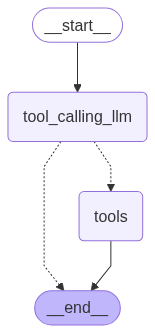

In [21]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
response = app.invoke({"messages":"what is weather of islambad today?"})

In [23]:
response = app.invoke({"messages":"what is 10 multiply 10"})

In [31]:
response["messages"][-1].content

'100'

In [25]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is 10 multiply 10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_yAEF1aKQ5rMcc9qhpcar59wk)
 Call ID: call_yAEF1aKQ5rMcc9qhpcar59wk
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: multiply

100


## React

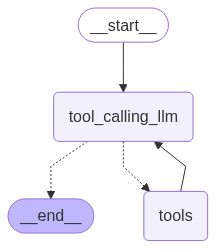

In [32]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


graph = StateGraph(State)

graph.add_node("tool_calling_llm",tool_calling_condition)

graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tool_calling_llm")

graph.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is a tool call -> tool condition route to tools
    # if the latest message from assistant is not tool call -> tool condtion route to END
    tools_condition
)

graph.add_edge("tools","tool_calling_llm")

app = graph.compile()

from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
response = app.invoke({"messages":"Give me recent news about AI and then multiply 5 by 11"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Give me recent news about AI and then multiply 5 by 11
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_hrwG9YLCqJpFh5uLkmYeFVJ6)
 Call ID: call_hrwG9YLCqJpFh5uLkmYeFVJ6
  Args:
    query: Recent news about AI
    search_depth: advanced
  multiply (call_wBENwpI7xHEPfp0uHMI3cQnM)
 Call ID: call_wBENwpI7xHEPfp0uHMI3cQnM
  Args:
    a: 5
    b: 11
================================= Tool Message =================================
Name: tavily_search

{"query": "Recent news about AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAgoHEXURk_JVbnhtiHZW-Yl2HSnitepZFZGZ9UAMV8cPq8qX0sUISpi&gaa_ts=685975af&gaa_sig=cOJFMYnzffUfM4nvNpl9rvR0ElH1bG7AfgiahhGBlAcbRXnA4P_laNRGFlsikhjVM3G_KaSFjXk41Zfn3TlDXw%3D%3D", "title": "Artificial Intelligence - Latest AI News and Analysis

In [41]:
response = app.invoke({"messages":"My name is haseeb"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

My name is haseeb
================================== Ai Message ==================================

Hello, Haseeb! How can I assist you today?


## Memory

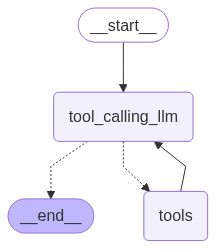

In [43]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_condition(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


graph = StateGraph(State)

graph.add_node("tool_calling_llm",tool_calling_condition)

graph.add_node("tools",ToolNode(tools))

graph.add_edge(START,"tool_calling_llm")

graph.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from assistant is a tool call -> tool condition route to tools
    # if the latest message from assistant is not tool call -> tool condtion route to END
    tools_condition)

graph.add_edge("tools","tool_calling_llm")

app = graph.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [45]:
config = {"configurable":{"thread_id" :"1"}}

response = app.invoke({"messages":"My name is Haseeb Manzoor"},config=config)
response

{'messages': [HumanMessage(content='My name is Haseeb Manzoor', additional_kwargs={}, response_metadata={}, id='d7b4f949-0dd9-415b-a4d3-9f6c6d126d50'),
  AIMessage(content='Hello, Haseeb Manzoor! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 813, 'total_tokens': 830, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BldchuFVqMzFDtFOoCJCIBdpI4GkC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e39d919-40e8-452f-bfe8-4a08812bd7af-0', usage_metadata={'input_tokens': 813, 'output_tokens': 17, 'total_tokens': 830, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasonin

In [ ]:
response = app.invoke({"messages":"what is my name"},config=config)
response

{'messages': [HumanMessage(content='My name is Haseeb Manzoor', additional_kwargs={}, response_metadata={}, id='d7b4f949-0dd9-415b-a4d3-9f6c6d126d50'),
  AIMessage(content='Hello, Haseeb Manzoor! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 813, 'total_tokens': 830, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BldchuFVqMzFDtFOoCJCIBdpI4GkC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e39d919-40e8-452f-bfe8-4a08812bd7af-0', usage_metadata={'input_tokens': 813, 'output_tokens': 17, 'total_tokens': 830, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasonin

In [47]:
response["messages"][-1].content

'Your name is Haseeb Manzoor.'

## Streaming

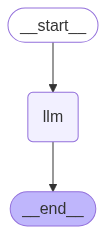

In [55]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def tool_calling_condition(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}


graph = StateGraph(State)

graph.add_node("llm",tool_calling_condition)

graph.add_edge(START,"llm")

graph.add_edge("llm",END)

app = graph.compile(checkpointer=memory)

from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [60]:
config = {"configurable": {"thread_id": "5"}}

response = app.stream({"messages":"my name is haseeb and i am 24 year old"},config=config,stream_mode="updates")

for chunk in response:
    print(chunk)


# with streaming_mode = updates  only AI message is being displayed

{'llm': {'messages': [AIMessage(content="Hello again, Haseeb! You've mentioned your name and age several times. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 953, 'total_tokens': 977, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-Ble6HVnz5a9YIPKdIZogFuPtXPIN5', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--107a3e52-6165-4b7f-b096-13d9be459e18-0', usage_metadata={'input_tokens': 953, 'output_tokens': 24, 'total_tokens': 977, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


In [61]:
response = app.stream({"messages":"my name is haseeb and i am 24 year old"},config=config,stream_mode="values")

for chunk in response:
    print(chunk)

# This is better

{'messages': [HumanMessage(content='my name is haseeb and i am 24 year old', additional_kwargs={}, response_metadata={}, id='97e45688-7684-4205-b659-d0f84f7739d9'), AIMessage(content="Hello, Haseeb! It's nice to meet you. You're 24 years old. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 817, 'total_tokens': 843, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-Ble0hBBbaQEPvfSDBVye8Dr93Hj6I', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9000560a-64a2-496d-ba00-2f10909feb0c-0', usage_metadata={'input_tokens': 817, 'output_tokens': 26, 'total_tokens': 843, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [64]:
import asyncio

config = {"configurable": {"thread_id": "9"}}

async def run():
    async for chunk in app.astream(
        {"messages": "my name is haseeb and i am 24 year old"},
        config=config,
        stream_mode="updates"
    ):
        print(chunk)

# Run the async function
asyncio.run(run())


RuntimeError: asyncio.run() cannot be called from a running event loop

## Human In Loop

In [24]:
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.types import Command,interrupt       # To provide Humman feed back

from langchain_core.tools import tool

from typing import  TypedDict,Annotated
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")
load_dotenv()

True

In [25]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [26]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")

In [27]:
from langchain_tavily import TavilySearch

search = TavilySearch()

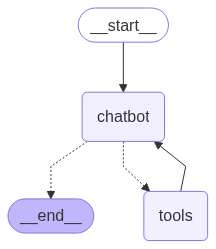

In [33]:
@tool
def human_assistance(query: str):
    """Request assistance from a human."""
    human_response = yield interrupt({"query": query})
    return human_response["data"]

tools = [search,human_assistance]
llm_with_tool = llm.bind_tools(tools)

graph = StateGraph(State)

def chatbot(state: State):
    response = llm_with_tool.invoke(state['messages'])
    return {"messages": [response]}



graph.add_node("chatbot",chatbot)
graph.add_edge(START,"chatbot")

tool_node = ToolNode(tools)
graph.add_node("tools",tool_node)

graph.add_conditional_edges(
    "chatbot",
    tools_condition)


graph.add_edge("tools","chatbot")


memory = MemorySaver()

app = graph.compile(checkpointer=memory)

from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = app.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_UTaK0NsjQjwIxZF60hbhPI0R)
 Call ID: call_UTaK0NsjQjwIxZF60hbhPI0R
  Args:
    query: Request expert guidance and assistance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

<generator object human_assistance at 0x00000294FA6FC1E0>
================================== Ai Message ==================================

I have sent a request for expert guidance and assistance in building an AI agent. If you need further help or specific information, please let me know!


In [38]:
humman_Response = """ we are the expert in langgraph we recomend to you to check langgraph official documents.
"""


human = Command(resume={"data":humman_Response})

events = app.stream(
    human,
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================== Ai Message ==================================

I have sent a request for expert guidance and assistance in building an AI agent. If you need further help or specific information, please let me know!
